# Analysis of benchmark times

In this notebook, we'll load some data about DaCapo benchmarks. The data contains running times for different "variants" of the benchmarks, and information about the context in which the benchmark is run (machine, startup / steady state, etc). We'll analyse this data to see if context influences the effect of the changes we've made to variants.

In [1]:
benchmark = "bloat"

"bloat"

In [2]:
using CSV, DataFrames, Plots, StatsPlots

In [3]:
data = CSV.read("data/$benchmark.csv", DataFrame);

In [4]:
names(data)

10-element Vector{String}:
 "status"
 "running-time"
 "converged"
 "first-run"
 "variant-type"
 "run-number"
 "jvm-invocation"
 "benchmark"
 "label"
 "machine"

In [8]:
# These are specific to bloat
selected_variants = ["0->hasharraylist", "1->arraymap", "original"]

3-element Vector{String}:
 "0->hasharraylist"
 "1->arraymap"
 "original"

In [9]:
function label_rename(l, selected_variants)
    if l == "original"
        return l
    else 
        if l ∈ selected_variants
            i = indexin([l], selected_variants)[1]
            return "t$i"
        else
            return missing
        end
    end
end

label_rename (generic function with 1 method)

In [10]:
data[!,:treatment] = map(x -> label_rename(x, selected_variants), data[!,:label]);

In [11]:
# We remove the rows which aren't startup of converged runs
# It's a bit imporant to remove samples, because the MCMC sampling cost grows quite a lot with the number of samples
selected = filter(r -> r[:converged] || r[Symbol("first-run")], data) |>
    x -> filter(r -> r[Symbol("label")] ∈ selected_variants, x)

360×11 DataFrame
 Row │ status        running-time  converged  first-run  variant-type  run-num ⋯
     │ String15      Int64         Bool       Bool       String15      Int64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Startup               2095      false       true  original              ⋯
   2 │ Steady-state          1318       true      false  original
   3 │ Startup               2193      false       true  original
   4 │ Steady-state          1369       true      false  original
   5 │ Startup               2168      false       true  original              ⋯
   6 │ Steady-state          1367       true      false  original
   7 │ Startup               2081      false       true  original
   8 │ Steady-state          1380       true      false  original
   9 │ Startup               2106      false       true  original              ⋯
  10 │ Steady-state          1377       true      false  original
  11 │ Startup               2201      false       true  original
  ⋮  │      ⋮             ⋮            ⋮          ⋮           ⋮            ⋮   ⋱
 351 │ Startup               1827      false       true  ortho
 352 │ Steady-state          1043       true      false  ortho                 ⋯
 353 │ Startup               1830      false       true  ortho
 354 │ Steady-state           966       true      false  ortho
 355 │ Startup               1842      false       true  ortho
 356 │ Steady-state           976       true      false  ortho                 ⋯
 357 │ Startup               1823      false       true  ortho
 358 │ Steady-state           991       true      false  ortho
 359 │ Startup               1844      false       true  ortho
 360 │ Steady-state           977       true      false  ortho                 ⋯
                                                  6 columns and 339 rows omitted

# Data processing

We prepare the data for using with Turing. the model only accepts arrays of numbers, and we need to get the standardized log running time.

In [12]:
n_samples = nrow(selected)

360

In [13]:
unique(selected[!, :treatment])

3-element Vector{Union{Missing, AbstractString}}:
 "original"
 "t2"
 "t1"

In [14]:
using Statistics

In [15]:
# We make a small struct to go back and forth between standardized and normal values
# Not used?
struct Standardizer
    from_std
    to_std
end

function standardizer(values)
    mu = mean(values)

    sigma = std(values)

    to_std(xs) = (xs .- mu) ./ sigma

    from_std(xs) = xs .* sigma .+ mu

    return Standardizer(from_std, to_std)
end


standardizer (generic function with 1 method)

In [16]:
using VegaLite

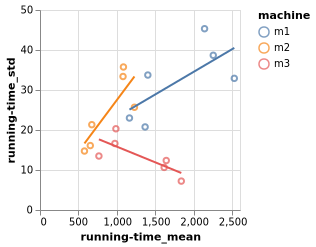

In [17]:
groupby(selected, [:status, :machine, :treatment]) |>
gs -> combine(gs, Symbol("running-time") => mean, 
                  Symbol("running-time") => std) |>
@vlplot(
    layer=[
        {mark=:point, x=Symbol("running-time_mean"), y=Symbol("running-time_std"), color=:machine},
        {mark=:line,
         transform=[{regression=Symbol("running-time_std"),
                     on=Symbol("running-time_mean"),
                     groupby=[:machine]}],
         y=Symbol("running-time_std"), x=Symbol("running-time_mean"), color=:machine}
        ])

Seems like variance increases with running time, except for M3.

In [18]:
groupby(selected, [:machine]) |> gs -> combine(gs, Symbol("running-time")=>mean)

3×2 DataFrame
 Row │ machine  running-time_mean 
     │ String3  Float64           
─────┼────────────────────────────
   1 │ m1                1808.14
   2 │ m2                 882.817
   3 │ m3                1303.08

Interesting fact, the difference between fastest and slowest machine is ~2x for bloat, but it's ~5x for avrora!

In [19]:
# columns
names(selected)

11-element Vector{String}:
 "status"
 "running-time"
 "converged"
 "first-run"
 "variant-type"
 "run-number"
 "jvm-invocation"
 "benchmark"
 "label"
 "machine"
 "treatment"

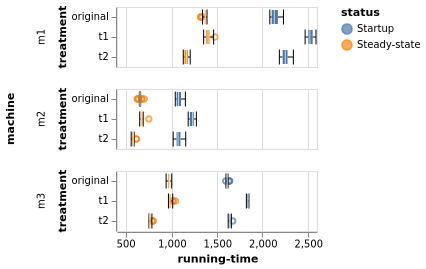

In [20]:
p = selected |> 
    @vlplot({type=:boxplot, ticks=true}, color=:status, y=:treatment, row=:machine,
        x={field=Symbol("running-time"), scale={zero=false}})

In [21]:
save("figures/bloat_boxplots.pdf", p)

We will use regression against the log of the running times, for three reasons:

1. Running time is always positive
2. The variance seems to increase with the running time
3. The distributions are skewed to the left (long-ish tail)

In [22]:
# We transform columns into arrays of indices
benchmarks = unique(selected[!, :benchmark]);
machines = unique(selected[!, :machine]);
treatments = unique(selected[!, :treatment]);
warmups = ["Startup", "Steady-state"]

selected[!, :warmup_ids] = indexin(selected[!, :status], warmups);
selected[!, :machine_ids] = indexin(selected[!, :machine], machines);
selected[!, :treatment_ids] = indexin(selected[!, :treatment], treatments);

In [23]:
# Now we process the running times
running_time_log = map(log, selected[!, Symbol("running-time")])

running_time_log_centered = running_time_log .- mean(running_time_log);

In [24]:
# We center the times around the mean
selected[!, :log_running_time] = running_time_log
selected[!, :centered_log_running_time] = running_time_log_centered;

WARN Infinite extent for field "centered_log_running_time": [Infinity, -Infinity]
WARN Infinite extent for field "centered_log_running_time": [Infinity, -Infinity]


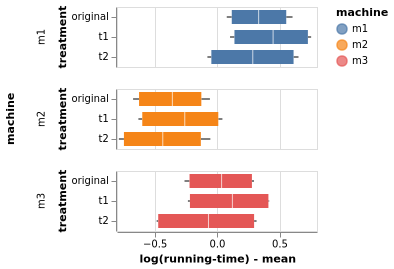

In [25]:
p = selected |> 
    @vlplot(:boxplot, color=:machine, y=:treatment, row=:machine,
        x={field=:centered_log_running_time,
           title="log(running-time) - mean"})

In [26]:
save("figures/bloat_boxplots_transformed.pdf", p)

WARN Infinite extent for field "centered_log_running_time": [Infinity, -Infinity]


# Statistical Models

To analyse the effect of each treatment (that is, how fast each variant runs compared to the original), we will use: 

1. A frequentist model
2. A no-pooling linear model
3. two hierarchical linear models. 

The hierarchical models are:

1. A model where the treatment effect doesn't vary with the context
2. A model where there is an interaction between context and treatment effect

## Training and test set

We'll split the data into training and test set.

In [27]:
selected[!,:running_time] = selected[!, Symbol("running-time")];

In [28]:
limit = 10

10

In [29]:
training = filter(r -> r[Symbol("jvm-invocation")] < limit, selected);

In [30]:
test = filter(r -> r[Symbol("jvm-invocation")] >= limit, selected);

In [31]:
nrow(training)

180

## Model 1.1: No interactions, Frequentist model

In [32]:
using GLM

In [33]:
contrasts = Dict(:treatment => StatsModels.DummyCoding(base="original"),
                 :machine => StatsModels.FullDummyCoding(),
                 :status => StatsModels.FullDummyCoding())

Dict{Symbol, AbstractContrasts} with 3 entries:
  :status    => FullDummyCoding()
  :treatment => DummyCoding("original", nothing)
  :machine   => FullDummyCoding()

In [34]:
@time(
freq_model = lm(@formula(centered_log_running_time ~ machine + status + treatment),
    training,
    contrasts = contrasts)
)

 13.355377 seconds (28.35 M allocations: 1.596 GiB, 3.79% gc time, 99.83% compilation time)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

centered_log_running_time ~ 1 + machine + status + treatment

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────
                           Coef.    Std. Error       t  Pr(>|t|)    Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
(Intercept)           -0.280712     0.00943413  -29.75    <1e-69   -0.299332    -0.262092
machine: m1            0.336191     0.00943413   35.64    <1e-81    0.317571     0.354811
machine: m2           -0.379818     0.00943413  -40.26    <1e-89   -0.398438    -0.361198
machine: m3            0.0        NaN           NaN       NaN     NaN          NaN
status: Startup        0.590235     0.00770294   76.62    <1e-99    0.575032     0.605439
status: Steady-state   0.0    

In [35]:
# With this you can show how the regression model encodes categorical variables.
StatsModels.modelmatrix(freq_model)

180×8 Matrix{Float64}:
 1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 ⋮                        ⋮         
 1.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0
 1.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0
 1.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0
 1.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0
 1.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0
 1.0  0.0  0.0  1.0 

In [36]:
function R2(model, X::DataFrame, y::Vector{T}) where {T}
    predictions = predict(model, X)
    
    tss = y .- mean(y) |> x -> x.^2 |> sum
    ess = y .- predictions |> x -> x.^2 |> sum
    
    return 1 - ess / tss
end

R2 (generic function with 1 method)

In [37]:
R2(freq_model, 
   test[!, [:machine, :status, :treatment]],
   test[!, :centered_log_running_time]) |> x -> round(x, digits=3)

0.986

The frequentist model gets **98% accuracy on the test set**.

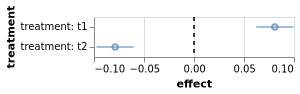

In [38]:
# Plotting the effect of treatments
p_freq_0 = DataFrame(:coefficient => coefnames(freq_model),
    :coef => coef(freq_model),
    :stderr => stderror(freq_model),
    :coef_min => confint(freq_model)[:,1],
    :coef_max => confint(freq_model)[:,2]) |>
    df -> filter(r -> occursin("treatment", r[:coefficient]), df) |>
    @vlplot(
    y={field=:coefficient, title="treatment"},
    width=200,
    layer=[
        {mark=:point, x={field=:coef, scale={zero=false}, title="effect"}},
        {mark={:rule, color="steelblue"}, x=:coef_min, x2=:coef_max},
        {mark={type=:rule, strokeDash=[4,4]}, x={datum=0.0}, y={value=0.0}, y2={value="height"}}
    ]
)

In [39]:
save("figures/plot_effects_no_interaction_freq_$benchmark.svg", p_freq_0)

This plot looks exactly like the plot you obtain from the bayesian model (no interactions)

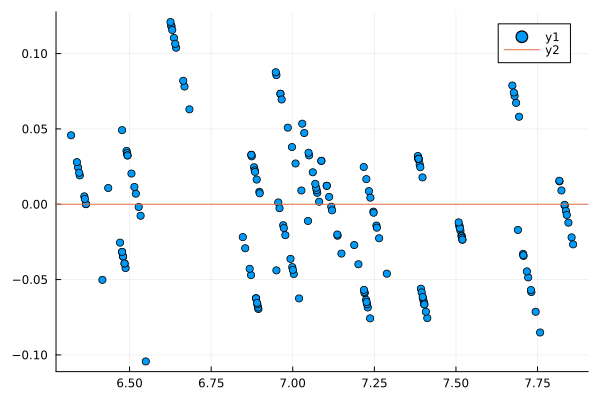

In [40]:
# Residuals
residuals_test = predict(freq_model, test[!, [:machine,:treatment,:status]]) .- test[!, :centered_log_running_time]

scatter(test[!, :log_running_time], residuals_test)
    
hline!([0.0])

In [41]:
fit(Normal, residuals_test)

Normal{Float64}(μ=0.0010927344300956827, σ=0.04948134220450738)

In [42]:
using Distributions

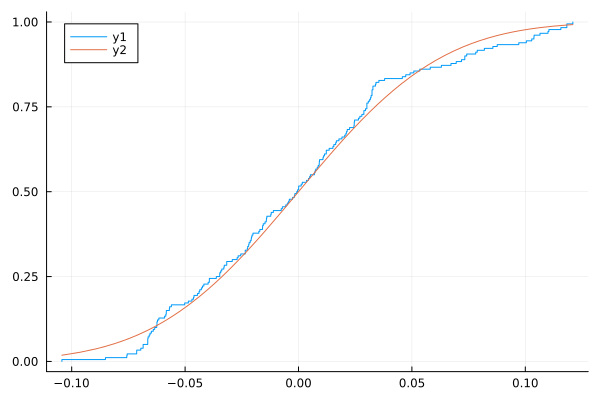

In [43]:
ecdfplot(residuals_test)
plot!(x -> cdf(Normal(0.0, 0.05), x))

Seems like we can safely assume that noise is normally distributed.

# Model 1.2: Frequentist model with interactions

In [44]:
# Let's try with interactions.
@time(
freq_model_interactions = lm(
    @formula(centered_log_running_time ~ 1 + machine + status + (treatment & (status + machine))),
    training,
    contrasts = contrasts
)
)

  2.517132 seconds (4.24 M allocations: 233.789 MiB, 3.62% gc time, 99.59% compilation time)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

centered_log_running_time ~ 1 + machine + status + treatment & status + treatment & machine

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.    Std. Error       t  Pr(>|t|)    Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                            0.0959271    0.00784298   12.23    <1e-24    0.0804436    0.111411
machine: m1                            0.0        NaN           NaN       NaN     NaN          NaN
machine: m2                           -0.708618     0.00960565  -73.77    <1e-99   -0.727581    -0.689655
machine: m3                           -0.311161     0.00960565  -32.39    <1e-73

In [45]:
r2(freq_model_interactions)

0.9952016420123516

In [46]:
R2(freq_model_interactions,
    test[!, [:machine, :status, :treatment]],
    test[!, :centered_log_running_time]) |> x -> round(x, digits=3)

0.996

The frequentist model with interactions has an **accuracy of 99%**. 

# Plotting the effects

In [47]:
function parse_coef_label(label)
    kvps = split(label, "&") |> words -> map(x -> strip(x), words)
    
    pairs = []
    
    for kvp in kvps
        splitted = split(kvp, ":")
        k = strip(splitted[1])
        v = strip(splitted[2])
        append!(pairs, [(k => v)])
    end
    
    return Dict(pairs)
end

parse_coef_label (generic function with 1 method)

In [48]:
function DataFrame(lin_model::StatsModels.TableRegressionModel)
    records = []
    
    for i in 1:length(coefnames(lin_model))
        name = coefnames(lin_model)[i]
        if name == "(Intercept)"
            continue 
        end
        interaction_info = parse_coef_label(name)
        
        value = coef(lin_model)[i]
        value_intervals = confint(lin_model)[i,:]
        
        record = (treatment=get(interaction_info,"treatment", missing),
            machine=get(interaction_info, "machine", missing),
            status=get(interaction_info, "status", missing),
            value=value,
            min=value_intervals[1],
            max=value_intervals[2])
        
        append!(records, [record])
    end
    return DataFrame(records)
end

DataFrame

In [49]:
model_df = DataFrame(freq_model_interactions)

15×6 DataFrame
 Row │ treatment   machine     status        value       min          max      ⋯
     │ SubStrin…?  SubStrin…?  SubStrin…?    Float64     Float64      Float64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ missing     m1          missing        0.0        NaN          NaN      ⋯
   2 │ missing     m2          missing       -0.708618    -0.727581    -0.6896
   3 │ missing     m3          missing       -0.311161    -0.330125    -0.2921
   4 │ missing     missing     Startup        0.487726     0.472242     0.5032
   5 │ missing     missing     Steady-state   0.0        NaN          NaN      ⋯
   6 │ t1          missing     Startup        0.148252     0.126355     0.1701
   7 │ t2          missing     Startup       -0.0157469   -0.0376439    0.0061
   8 │ t1          missing     Steady-state   0.0362084    0.0143114    0.0581
   9 │ t2          missing     Steady-state  -0.211232    -0.233129    -0.1893 ⋯
  10 │ t1          m1          missing        0.0        NaN          NaN
  11 │ t2          m1          missing        0.0557274    0.0289092    0.0825
  12 │ t1          m2          missing       -0.0148315   -0.0416497    0.0119
  13 │ t2          m2          missing        0.0483877    0.0215695    0.0752 ⋯
  14 │ t1          m3          missing       -0.0193608   -0.046179     0.0074
  15 │ t2          m3          missing        0.0        NaN          NaN
                                                                1 column omitted

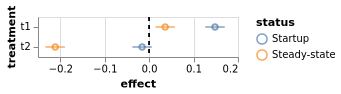

In [50]:
model_df |>
    df -> filter(r -> !ismissing(r[:treatment]), df) |>
    df -> filter(r -> !ismissing(r[:status]), df) |>
    @vlplot(
    y=:treatment,
    x={field=:value, title="effect", zero=false},
    layer=[
        {mark=:point, x={field=:value, scale={zero=false}}, y=:treatment, color=:status},
        {mark=:rule, x=:min, x2=:max, y=:treatment, color=:status},
        {mark={type=:rule, strokeDash=[4,4]}, x={datum=0.0}, y={value=0.0}, y2={value="height"}}
    ]
)

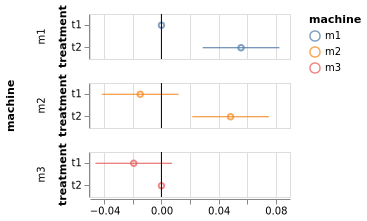

In [51]:
p_freq_interactions = model_df |>
    df -> filter(r -> !ismissing(r[:treatment]), df) |>
    df -> filter(r -> !ismissing(r[:machine]), df) |>
    @vlplot(
    facet={row={field=:machine}},
    spec={layer=[
        {mark=:point, x={field=:value, scale={zero=false}}, y=:treatment, color=:machine},
        {mark=:rule, x=:min, x2=:max, y=:treatment, color=:machine},
        {mark=:rule, x=[0.0]},
        ],
        height=45
    },
)

In [52]:
save("figures/plot_effect_machine_treatment_freq_$benchmark.svg",p_freq_interactions)

In [53]:
ftest(freq_model.model, freq_model_interactions.model)

F-test: 2 models fitted on 180 observations
────────────────────────────────────────────────────────────────
     DOF  ΔDOF     SSR     ΔSSR      R²     ΔR²       F*   p(>F)
────────────────────────────────────────────────────────────────
[1]    7        0.4646           0.9856                         
[2]   13     6  0.1550  -0.3096  0.9952  0.0096  55.9207  <1e-36
────────────────────────────────────────────────────────────────

We can see:

- the second model gets fits the data a bit better.
- t2 is slightly faster on m3 than on m1, m2
- t2 is much faster in steady state

## Summary of Frequentist regression

These plots are similar to what we will obtain with the Bayesian model, except in the Frequentist case, I get the interaction of treatment and machine relative to one specific machine (not sure why). Apart from that, the coefficients (and the error) we get are similar to what we will obtain through the Bayesian model.

The frequentist models are *very* accurate already, with only three jvm iterations.

# Bayesian Models

## Model 2.1: Context does not matter

We assume that the machine used and the warmup effect have an effect on the runtime, but the effect of a treatment (collection change) is the same regardless.

## Machines
We set a prior on the effect of the machine, compared to the mean. The effect is normally distributed with mean 0.0 and $\sigma$ inferred from the data. There is one independent effect for each machine, but the standard deviation is pooled across machines.

$$
\sigma_{machines} \sim \text{Exponential}(0.5)\\
\alpha_{m} \sim \text{Normal}(0.0, \sigma_{machines})
$$

## Warmup
We set a similar prior for the effect of warmup: Normally distributed, with a $\sigma$ that is learned from the data. There are two warmup states, so two priors.

$$
\sigma_{warmups} \sim \text{Exponential}(0.5)\\
\beta_{startup} \sim \text{Normal}(0.0, \sigma_{warmups})\\
\beta_{steady} \sim \text{Normal}(0.0, \sigma_{warmups})
$$

## Treatments
Similarly, for each treatment, we set a Normal prior for its effect, but the $\sigma$ of the distribution is learned from the data. Instead of using an exponential prior, we use a truncated Normal. The reason for this is that the thinner tail of the normal helps with sampling. 

$$
\sigma_{treatments} \sim \text{Exponential}(0.1)\\
\gamma_{t} \sim \text{Normal}(0.0, \sigma_{treatments})\\
$$


## Likelihood
We consider the log running time of the program is the sum of these effects plus some gaussian noise.

$$
\mu_j = \alpha_{M[j]} + \beta_{W[j]} + \gamma_{T[j]}\\
\sigma \sim \text{Exponential(0.1)}\\
\log(\text{running_time}_j) \sim \text{Normal}(\mu_j, \sigma)\\
$$

In [54]:
using Turing, FillArrays, Distributions, LinearAlgebra

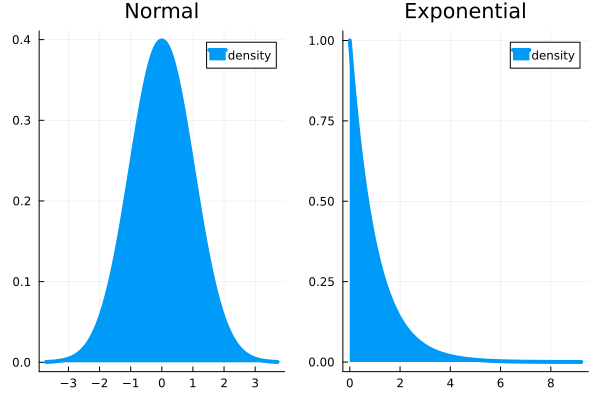

In [55]:
# We'll use two distributions so I'll plot them
p = plot(plot(Normal(), title="Normal"),
         plot(Exponential(), title="Exponential"),
    fill=true, w=4, label="density")

In [56]:
savefig(p, "figures/distributions.pdf")

In [57]:
# A hierarchical model where we run the ANOVA and the regression together.
@model function treatment_model_no_context(
        nmachines,
        ntreatments,
        machine_idxs, warmup_idxs, treatment_idxs,
        running_time_obs_std, ::Type{T}=Float64) where T
    
    # We assume the mean running time is zero
    # (I think I have enough data-points to assume
    # there's little uncertainty about that, and centering is enough)

    # Effect of the machine
    sigma_machines ~ Exponential(0.4)
    effect_machine ~ MvNormal(Fill(0.0, nmachines), sigma_machines)

    # Effect of the warmup
    sigma_warmup ~ Exponential(0.4)
    effect_warmup ~ MvNormal(Fill(0.0, 2), sigma_warmup)
    
    # Effect of treatment
    sigma_treatments ~ Exponential(0.1)
    effect_treatment ~ MvNormal(Fill(0.0, ntreatments), sigma_treatments)

    sigma ~ Exponential(0.1)

    N = length(running_time_obs_std)
    running_time = Vector{T}(undef, N)
    for i in 1:N
        machine_i = machine_idxs[i]
        warmup_i = warmup_idxs[i]
        treatment_i = treatment_idxs[i]

        effects_jvm = effect_machine[machine_i] + effect_warmup[warmup_i]

        # 0.0 is the average time
        running_time[i] = effects_jvm + effect_treatment[treatment_i]

    end
    
    running_time_obs_std ~ MvNormal(running_time, sigma^2 .* I)
    
    # Useful for the Bayesian R2
    line_variance = var(running_time)
    residuals_variance = sigma*sigma
    R2 = line_variance / (line_variance + residuals_variance)
   
    return (finite_sd_machine=std(effect_machine),
            finite_sd_warmup=std(effect_warmup),
            finite_sd_treatments=std(effect_treatment),
            finite_sd_residuals=std(running_time .- running_time_obs_std),
            r2=R2)
end

treatment_model_no_context (generic function with 3 methods)

# Inference

In [58]:
model_h0 = treatment_model_no_context(length(machines),
                                      length(treatments),
                                      training[!, :machine_ids], 
                                      training[!, :warmup_ids],
                                      training[!, :treatment_ids],
                                      training[!, :centered_log_running_time]);

In [59]:
function sample_model(model::DynamicPPL.Model)
    # These lines made the model go from 10 minutes / chain to 1 minute / chain (!)
    # Source: https://discourse.julialang.org/t/multi-level-varying-slopes-with-two-clusters-cross-classification/62036/6?u=neal
    # Turing.setadbackend(:reversediff)
    # Turing.setrdcache(true)

    nuts_sampler = NUTS(0.7)

    chain = sample(model, nuts_sampler, MCMCSerial(), 1000, 4)

    return chain
end

sample_model (generic function with 1 method)

In [60]:
chain_h0 = sample_model(model_h0);

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/vetii/.julia/packages/Turing/Oczpc/src/inference/hmc.jl:188
Sampling (Chain 1 of 4): 100%|██████████████████████████| Time: 0:00:15
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/vetii/.julia/packages/Turing/Oczpc/src/inference/hmc.jl:188
Sampling (Chain 2 of 4): 100%|██████████████████████████| Time: 0:00:11
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/vetii/.julia/packages/Turing/Oczpc/src/inference/hmc.jl:188
Sampling (Chain 3 of 4): 100%|██████████████████████████| Time: 0:00:12
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/vetii/.julia/packages/Turing/Oczpc/src/inference/hmc.jl:188
Sampling (Chain 4 of 4): 100%|██████████████████████████| Time: 0:00:11


In [61]:
ess_rhat(chain_h0)

ESS
           parameters         ess      rhat   ess_per_sec 
               Symbol     Float64   Float64       Float64 

       sigma_machines   2016.1653    0.9999       25.3068
    effect_machine[1]    668.8118    1.0016        8.3949
    effect_machine[2]    668.4732    1.0016        8.3906
    effect_machine[3]    667.5869    1.0016        8.3795
         sigma_warmup   2116.6298    0.9995       26.5678
     effect_warmup[1]    671.3020    1.0028        8.4261
     effect_warmup[2]    671.0443    1.0029        8.4229
     sigma_treatments   1573.0074    1.0032       19.7443
  effect_treatment[1]   1064.7429    1.0054       13.3646
  effect_treatment[2]   1066.6887    1.0061       13.3890
  effect_treatment[3]   1072.5372    1.0056       13.4624
                sigma   2892.0691    0.9996       36.3011


ess is reasonably close to the number of samples we took, so we can assume that the sampling worked well enough.

In [62]:
fit(LogNormal,chain_h0[:sigma_machines])

LogNormal{Float64}(μ=-0.9501789232068558, σ=0.43236397332760285)

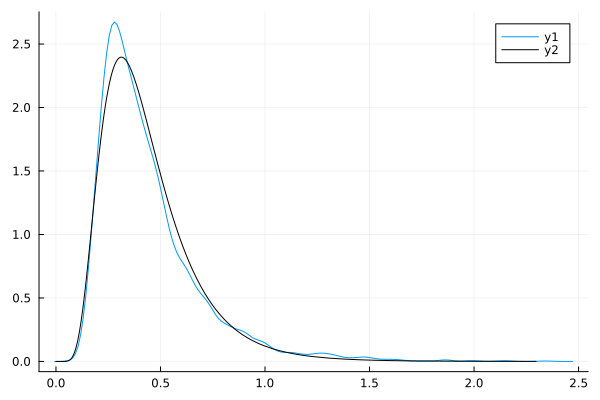

In [63]:
density(chain_h0[:sigma_warmup] |> vec)
plot!(fit(LogNormal, chain_h0[:sigma_warmup]), color="black")

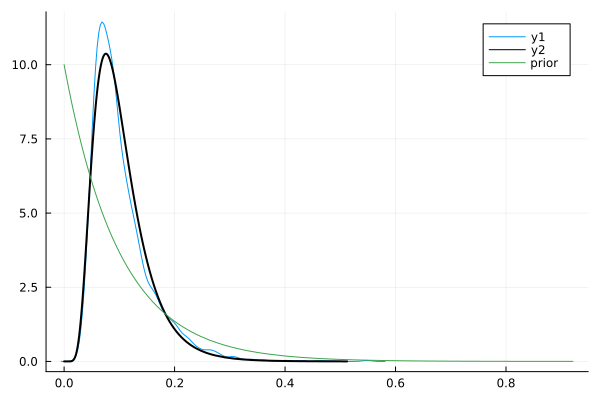

In [64]:
density(chain_h0[:sigma_treatments] |> vec)
plot!(fit(LogNormal, chain_h0[:sigma_treatments]), linewidth=2.0, color="black")
plot!(Exponential(0.1), label="prior")

In [65]:
fit(LogNormal, chain_h0[:sigma_treatments])

LogNormal{Float64}(μ=-2.372390600468555, σ=0.45810545703997185)

We can see that we $\sigma$s started as exponential, but now they look like log-normal distributions. Perhaps I could use that at some point.

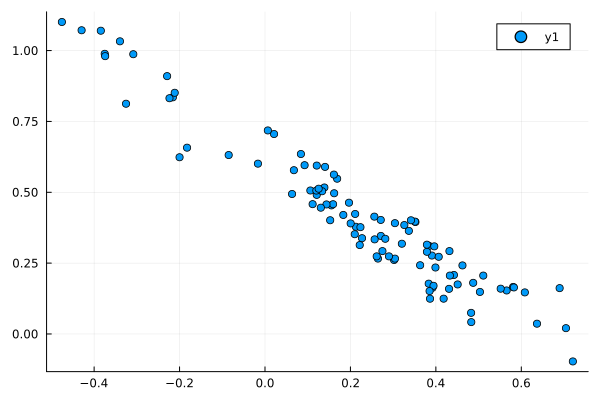

In [66]:
scatter(chain_h0["effect_machine[1]"][1:100], chain_h0["effect_warmup[1]"][1:100])

This high correlation between machine effects and warmup effects is explained by the model: Since the running time is proportional to the *sum* of `effect_machine[1]` and `effect_warmup[1]`, increasing the first requires to decrease the other. This effect ripples to other variables (all `effect_machine` are increased). As a result, `effect_machine[1]` and `effect_machine[2]` are highly correlated. 

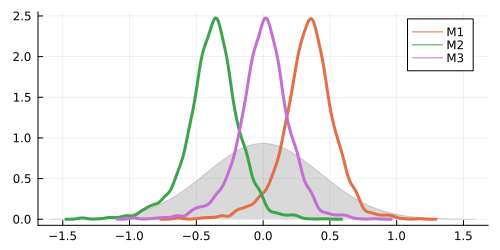

In [67]:
# Plotting the effects of machines, put the hyperprior in the background

p = plot()


sigma_machines_est = chain_h0["sigma_machines"] |> vec |> mean


plot!(p, Normal(0.0, sigma_machines_est), fill=true, color="black", opacity=0.15, label=missing)

size_paper = (300, 125)
size_presentation = (500, 250)

for m in 1:3
    density!(p, chain_h0["effect_machine[$m]"] |> vec,
        label="M$m",
        linewidth=3, size=size_presentation)
end


p

In [68]:
savefig(p, "figures/plot_family_distribution_$benchmark.pdf")

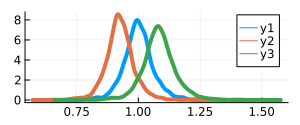

In [69]:
# Effect of treatments

p = plot()

presentation_labels = ["γ1", "γ2", "γ_base"]
for t in 1:3
    density!(chain_h0["effect_treatment[$t]"] |> vec |> v -> exp.(v), w=4, size=size_paper)
end

p

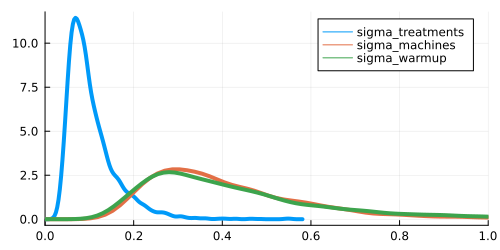

In [70]:
# Importance of treatments vs machines and warmup.
labels = ["treatments", "machines", "warmup"]

p = plot(xrange=(0,1.0))

for n in labels
    v = "sigma_$n"
    samples = chain_h0[v] |> vec
    density!(p, samples, label=v, w=4, size=size_presentation)
end
p

We can see that the treatments have less of an impact on running time than switching to a different machine, or just waiting for starting up.

# Analysis

We can now use the chain of samples to investigate how well the model work, and what it says.

## Posterior predictive accuracy

We try to see if the model can predict accurately the log running times. We need to create a new model, but we use the chain we obtained from the training set.

In [71]:
# Same model, but we pass "missing" as data, so the model tries to guess it.
model_pred_h0 = treatment_model_no_context(length(machines),
                                           length(treatments),
                                           test[!, :machine_ids], 
                                           test[!, :warmup_ids],
                                           test[!, :treatment_ids],
                                           test[!, :centered_log_running_time]);

In [72]:
# Let's plot the Bayesian R2 as described in (Gelman 2021)

chain_params = Turing.MCMCChains.get_sections(chain_h0, :parameters)
generated_h0 = generated_quantities(model_pred_h0, chain_params);

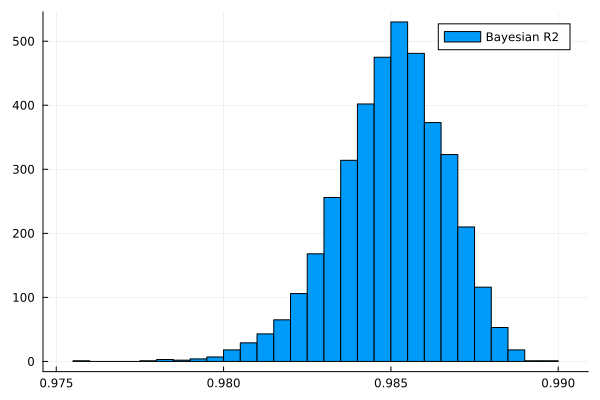

In [73]:
r2_h0 = map(x -> x.r2, generated_h0) |> vec
histogram(r2_h0, label="Bayesian R2")

# Plotting effects

We will plot the effects of treatments, etc, like we did for the frequentist models.

In [74]:
using VegaLite

In [75]:
function chain_to_df(chain, treatments)
    baseline = indexin(["original"], treatments)[1]
    baseline_samples = vec(chain["effect_treatment[$baseline]"])
    
    records = []
    
    for t_i in 1:length(treatments)
        t = treatments[t_i]

        if t_i == baseline
            continue
        end
        
        samples = vec(chain["effect_treatment[$t_i]"]) .- baseline_samples |> s -> exp.(s)
        
        for s in samples
            record = (treatment=t, value=s)
            append!(records, [record])
        end
    end

    return DataFrame(records)
end

chain_to_df (generic function with 1 method)

In [76]:
function chain_h0_to_df(chain, treatments)
    records = []
    
    baseline = indexin(["original"], treatments)[1]
    
    baseline_samples = vec(chain["effect_treatment[$baseline]"])
    
    records = []
    
    for t_i in 1:length(treatments)
        t = treatments[t_i]

        if t_i == baseline
            continue
        end
        
        samples = vec(chain["effect_treatment[$t_i]"]) .- baseline_samples |> s -> exp.(s)
        
        record = (treatment=t,
            effect_med=(quantile(samples, 0.5)), 
            effect_50_min=(quantile(samples, 0.25)),
            effect_50_max=(quantile(samples, 0.75)),
            effect_95_min=(quantile(samples, 0.025)),
            effect_95_max=(quantile(samples, 0.975)))
        
        append!(records, [record])
    end

    return DataFrame(records)
end

chain_h0_to_df (generic function with 1 method)

In [77]:
df_h0 = chain_h0_to_df(chain_h0, treatments)

2×6 DataFrame
 Row │ treatment  effect_med  effect_50_min  effect_50_max  effect_95_min  eff ⋯
     │ String     Float64     Float64        Float64        Float64        Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ t2           0.924804       0.919334       0.930203        0.90874      ⋯
   2 │ t1           1.08369        1.07683        1.09068         1.06402
                                                                1 column omitted

In [78]:
# We select the significant effects.
df_filtered = filter(r -> !(r[:effect_50_min] < 1.0 && r[:effect_50_max] > 1.0), df_h0)

2×6 DataFrame
 Row │ treatment  effect_med  effect_50_min  effect_50_max  effect_95_min  eff ⋯
     │ String     Float64     Float64        Float64        Float64        Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ t2           0.924804       0.919334       0.930203        0.90874      ⋯
   2 │ t1           1.08369        1.07683        1.09068         1.06402
                                                                1 column omitted

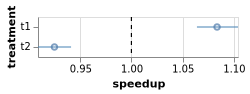

In [79]:
plot_effects_no_interaction = 
    df_filtered |> @vlplot(
            y=:treatment,
            x={scale={nice=false}},
            width=200,
            layer=[
            {mark={type=:rule, color=:steelblue}, x=:effect_95_min, x2=:effect_95_max},
            # {mark={type=:rule, color=:steelblue, strokeWidth=4, opacity=0.5},x=:effect_50_min, x2=:effect_50_max},
            {mark={type=:point}, x={field=:effect_med, scale={zero=false}, title="speedup"}},
            {mark={type=:rule, strokeDash=[4,4]}, x={datum=1.0}, y={value=0.0}, y2={value="height"}},
            ])

In [80]:
save("figures/plot_effects_no_interaction_$benchmark.svg", plot_effects_no_interaction)
save("figures/plot_effects_no_interaction_$benchmark.pdf", plot_effects_no_interaction)

# Model 2.2: Context does matter


This is almost the same model, but the machine and warmup interact with the effect of treatment.

## Machines
We set a prior on the effect of the machine, compared to the mean. The effect is normally distributed with mean 0.0 and $\sigma$ inferred from the data. There is one independent effect for each machine, but the standard deviation is pooled across machines.

$$
\sigma_{machines} \sim \text{Exponential}(0.5)\\
\bar{\alpha}_{m} \sim \text{Normal}(0.0, \sigma_{machine})
$$

## Warmup
We set a similar prior for the effect of warmup: Normally distributed, with a $\sigma$ that is learned from the data. There are two warmup states, so two priors.

$$
\sigma_{warmup} \sim \text{Exponential}(0.5)\\
\bar{\beta}_{startup} \sim \text{Normal}(0.0, \sigma_{warmup})\\
\bar{\beta}_{steady} \sim \text{Normal}(0.0, \sigma_{warmup})
$$

## Interactions
We are not only interested in the effect of the treatment. We're interested in how the effect of treatment *changes* with a different machine, or after warming up. Therefore, we add priors for an interaction term between the machine and the treatment, and another for the interaction between warmup and treatment.

### Treatment + Machine

$$
\sigma_{\text{interations_machine}} \sim \text{Exponential}(0.1)\\
\alpha_{m, t} \sim \text{Normal}(0.0, \sigma_{\text{interations_machine}})\\
$$

### Treatment + Warmup

$$
\sigma_{\text{interations_warmup}} \sim \text{Exponential}(0.1)\\
\beta_{warmup, t} \sim \text{Normal}(0.0, \sigma_{\text{interations_machine}})\\
\beta_{steady, t} \sim \text{Normal}(0.0, \sigma_{\text{interations_machine}})
$$

## Likelihood
We consider the log running time of the program is the sum of these effects plus some gaussian noise.

$$
\log(\text{running_time}_j) \sim \text{Normal}(\mu_j, \sigma)\\
\mu_j = \bar{\alpha}_{M[j]} + \alpha_{M[j], T[j]} + \bar{\beta}_{W[j]} + \beta_{W[j], T[j]}\\
\sigma \sim \text{Exponential(0.1)}
$$

In [81]:
# Model for treatment + interaction for machine + interaction for warmup
# Because I saw that if you split it in two different models, the estimation of MAIN effect of the treatment
# changes a bit!
@model function treatment_model_interactions(
        nmachines, ntreatments,
        machine_idxs, warmup_idxs, treatment_idxs,
        running_time_obs_std, ::Type{T}=Float64) where T

    # We assume the mean running time is zero
    # (I think I have enough data-points to assume
    # there's little uncertainty about that, and centering is enough)

    # Effect of the machine
    sigma_machines ~ Exponential(0.5)
    # This is the posterior for model h0
    # sigma_machines ~ LogNormal(-1, 0.5)
    effect_machine ~ MvNormal(Fill(0.0, nmachines), sigma_machines)

    # Effect of the warmup
    # sigma_warmup ~ Exponential(0.5)
    # This is the posterior for model h0
    sigma_warmup ~ LogNormal(-1, 0.5)
    effect_warmup ~ MvNormal(Fill(0.0, 2), sigma_warmup)
    
    # Interaction warmup + machine in a matrix
    # sigma_interactions_machine_warmup ~ Exponential(0.4)
    # effect_machine_warmup ~ filldist(Normal(0.0, sigma_interactions_machine_warmup),
    #                                  2, nmachines)

    # Effect of machine + Treatment
    # Posterior for h0
    # sigma_interactions_machine ~ LogNormal(-2.89, 0.22)
    sigma_interactions_machine ~ Exponential(0.05)
    effect_interaction_machine ~ filldist(Normal(0.0, sigma_interactions_machine),
                                          nmachines, ntreatments)

    # Effect of warmup + treatment
    # Posterior for h0
    # sigma_interactions_warmup ~ LogNormal(-2.89, 0.22)
    sigma_interactions_warmup ~ Exponential(0.05)
    effect_interaction_warmup ~ filldist(Normal(0.0, sigma_interactions_warmup),
                                         2, ntreatments)

    sigma ~ Exponential(0.1)

    N = length(running_time_obs_std)
    running_time = Vector{T}(undef, N)
    for i in 1:N
        machine_i = machine_idxs[i]
        warmup_i = warmup_idxs[i]
        treatment_i = treatment_idxs[i]

        effect_jvm = effect_machine[machine_i] + effect_warmup[warmup_i]
        # effect_jvm = effect_machine_warmup[warmup_i, machine_i]
        
        effects_treatment_total = effect_interaction_machine[machine_i, treatment_i] + effect_interaction_warmup[warmup_i, treatment_i]

        # 0.0 is the average time
        running_time[i] = effect_jvm + effects_treatment_total

        running_time_obs_std[i] ~ Normal(running_time[i], sigma)
    end
    
    # Useful for the Bayesian R2
    line_variance = var(running_time)
    residuals_variance = sigma*sigma
    R2 = line_variance / (line_variance + residuals_variance)
    
    return (# effect_machine_1=mean(effect_machine_warmup[:, 1]),
            # effect_machine_2=mean(effect_machine_warmup[:, 2]),
            # effect_machine_3=mean(effect_machine_warmup[:, 3]),
            # effect_startup=mean(effect_machine_warmup[1,:]),
            # effect_steady=mean(effect_machine_warmup[2,:]),
            r2=R2,
            finite_sd_machine=std(effect_machine),
            finite_sd_warmup=std(effect_warmup),
            finite_sd_treatment_machine=std(effect_interaction_machine),
            finite_sd_treatment_warmup=std(effect_interaction_warmup),
            finite_sd_residuals=std(running_time .- running_time_obs_std))
end


treatment_model_interactions (generic function with 3 methods)

In [82]:
model_h1 = treatment_model_interactions(length(machines),
                                        length(treatments),
                                        training[!, :machine_ids],
                                        training[!, :warmup_ids],
                                        training[!, :treatment_ids],
                                        training[!, :centered_log_running_time]);

In [83]:
# These lines made the model go from 10 minutes / chain to 1 minute / chain (!)
# Source: https://discourse.julialang.org/t/multi-level-varying-slopes-with-two-clusters-cross-classification/62036/6?u=neal
# But doesn't really work anymore... 
# using ReverseDiff, Memoization
# Turing.setadbackend(:reversediff)
# Turing.setrdcache(true)

# One thing that seemed to have a very positive effect is to replace loops 
# by operations on matrices / vectors.

chain_h1 = sample_model(model_h1);

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/vetii/.julia/packages/Turing/Oczpc/src/inference/hmc.jl:188
Sampling (Chain 1 of 4): 100%|██████████████████████████| Time: 0:01:16
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/vetii/.julia/packages/Turing/Oczpc/src/inference/hmc.jl:188
Sampling (Chain 2 of 4): 100%|██████████████████████████| Time: 0:01:18
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/vetii/.julia/packages/Turing/Oczpc/src/inference/hmc.jl:188
Sampling (Chain 3 of 4): 100%|██████████████████████████| Time: 0:01:21
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/vetii/.julia/packages/Turing/Oczpc/src/inference/hmc.jl:188
Sampling (Chain 4 of 4): 100%|██████████████████████████| Time: 0:01:12


In [84]:
ess_rhat(chain_h1)

ESS
                       parameters         ess      rhat   ess_per_sec 
                           Symbol     Float64   Float64       Float64 

                   sigma_machines   2406.6832    1.0003        7.2709
                effect_machine[1]   1063.5759    1.0021        3.2132
                effect_machine[2]   1051.2723    1.0022        3.1760
                effect_machine[3]   1051.7455    1.0021        3.1775
                     sigma_warmup   3350.1215    1.0008       10.1211
                 effect_warmup[1]   1048.3128    1.0030        3.1671
                 effect_warmup[2]   1066.2370    1.0035        3.2212
       sigma_interactions_machine    676.0121    1.0044        2.0423
  effect_interaction_machine[1,1]   3125.5168    1.0011        9.4426
  effect_interaction_machine[2,1]   3102.3072    1.0017        9.3724
  effect_interaction_machine[3,1]   3336.2461    0.9999       10.0792
  effect_interaction_machine[1,2]   2090.0653    1.0011        6.3143
  effect_inte

The diagnostics look pretty good (ess is pretty close to the number of samples)

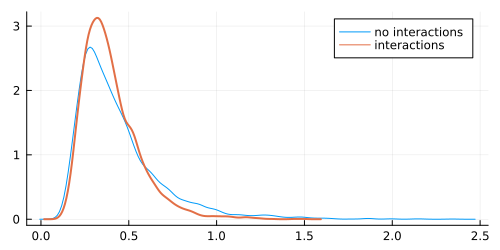

In [85]:
# Comparing importance of warmup effects
density(chain_h0[:sigma_warmup] |> vec, size=size_presentation,
    label="no interactions")
density!(chain_h1[:sigma_warmup] |> vec, linewidth=2, label="interactions")

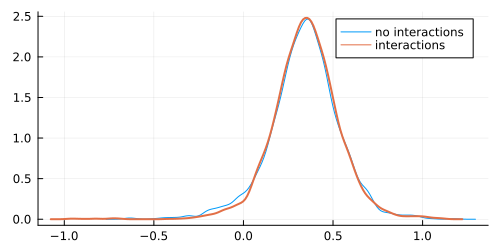

In [86]:
# Same for the effects of machines
density(chain_h0["effect_machine[1]"] |> vec, size=size_presentation, label="no interactions")
density!(chain_h1["effect_machine[1]"] |> vec, linewidth=2, label="interactions")

They look pretty similar!

In [87]:
ess_rhat(chain_h1) |> DataFrame |> df -> filter(r -> occursin("sigma", string(r[:parameters])), df)

5×4 DataFrame
 Row │ parameters                  ess       rhat      ess_per_sec 
     │ Symbol                      Float64   Float64   Float64     
─────┼─────────────────────────────────────────────────────────────
   1 │ sigma_machines              2406.68   1.00035       7.27088
   2 │ sigma_warmup                3350.12   1.00079      10.1211
   3 │ sigma_interactions_machine   676.012  1.0044        2.04231
   4 │ sigma_interactions_warmup   2075.42   1.00134       6.27008
   5 │ sigma                       4796.28   0.999642     14.4901

## Goodness of fit

In [88]:
model_pred_h1 = treatment_model_interactions(length(machines), length(treatments), 
                                             test[!, :machine_ids], 
                                             test[!, :warmup_ids], 
                                             test[!, :treatment_ids],
                                             test[!, :centered_log_running_time]);

In [89]:
chain_h1_params = Turing.MCMCChains.get_sections(chain_h1, :parameters)
generated_h1 = generated_quantities(model_pred_h1, chain_h1_params);

In [90]:
r2_h1 = map(x -> x.r2, generated_h1) |> vec;

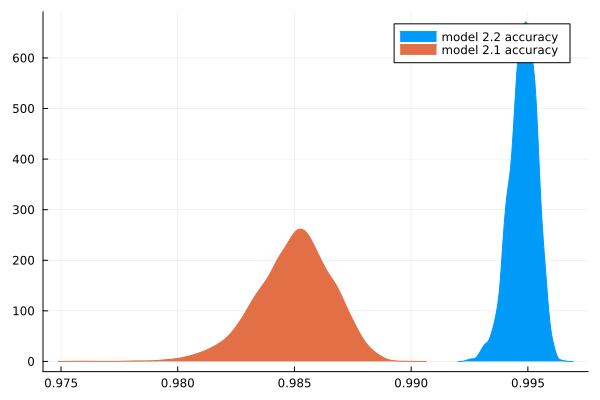

In [91]:
density(r2_h1, label="model 2.2 accuracy", fill=true)
density!(r2_h0, label="model 2.1 accuracy", fill=true)

We can see that the accuracy is higher when we take the interactions between treatments and warmup / machines into account.

## Plotting effects

Here we plot the effect of interactions.

In [92]:
function chain_h1_to_df(treatments, interaction_type, interaction_values, chain)
    records = []
    
    baseline = indexin(["original"], treatments)[1]
    
    for t_i in 1:length(treatments)
        t = treatments[t_i]
        
        if t_i == baseline
            continue
        end

        # Interaction_values can be machines ["m1", "m2", ...]
        # Or "startup", "steady-state"
        for v_i in eachindex(interaction_values)
            v = interaction_values[v_i]
            
            samples_baseline = vec(chain["effect_interaction_$interaction_type[$v_i,$baseline]"])
            
            samples_trtmt = vec(chain["effect_interaction_$interaction_type[$v_i,$t_i]"])
            
            samples = samples_trtmt .- samples_baseline |> s -> exp.(s)

            record = (treatment=t, value=v, effect_type="interaction",
                effect_med=quantile(samples, 0.5),
                effect_50_min=quantile(samples, 0.25),
                effect_50_max=quantile(samples, 0.75),
                effect_95_min=quantile(samples, 0.025),
                effect_95_max=quantile(samples, 0.975))

            append!(records, [record])
        end
    end

    return DataFrame(records)
end

chain_h1_to_df (generic function with 1 method)

In [93]:
df_h1 = chain_h1_to_df(treatments, "warmup", ["startup", "steady-state"], chain_h1)

4×8 DataFrame
 Row │ treatment  value         effect_type  effect_med  effect_50_min  effect ⋯
     │ String     String        String       Float64     Float64        Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ t2         startup       interaction    1.02195        1.01008        1 ⋯
   2 │ t2         steady-state  interaction    0.841475       0.831389       0
   3 │ t1         startup       interaction    1.1423         1.12858        1
   4 │ t1         steady-state  interaction    1.0216         1.00912        1
                                                               3 columns omitted

In [94]:
using VegaLite

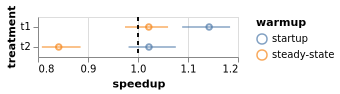

In [95]:
p = df_h1 |>
    @vlplot(
    y=:treatment,
    layer=[
        {mark=:point, 
         x={field=:effect_med, scale={zero=false}, title="speedup"},
         color={field=:value, title="warmup"}},
        {mark=:rule, x=:effect_95_min, x2=:effect_95_max, color=:value},
        # {mark={type=:rule, strokeWidth=4}, x=:effect_50_min, x2=:effect_50_max, color=:value},
        {mark={type=:rule, strokeDash=[4,4]}, x={datum=1.0}, y={value=0.0}, y2={value="height"}}
    ]
  )

We can see that the treatment interacts with the warmup.

In [96]:
VegaLite.save("figures/bayesian-estimate-context-warmup-$benchmark.svg", p)

In [97]:
function effect_machines(treatments, machines, chain)
    baseline = indexin(["original"], treatments)[1]
    
    
    records = []
    
    for m_i in eachindex(machines)
        baseline_samples = chain["effect_interaction_machine[$m_i,$baseline]"] |> vec
        
        for t_i in eachindex(treatments)
            if t_i == baseline
                continue
            end
            
            tmt_samples = chain["effect_interaction_machine[$m_i,$t_i]"] |> vec
            
            diff_samples = tmt_samples .- baseline_samples
            
            for s in diff_samples
                append!(records, [(machine=uppercase(machines[m_i]), treatment=treatments[t_i], effect=s)])
            end
        end
    end
    
    return DataFrame(records)
end

effect_machines (generic function with 1 method)

In [98]:
effect_machines_h1 = effect_machines(treatments, machines, chain_h1)
effect_machines_h1[!,:speedup] = exp.(effect_machines_h1[!,:effect]);

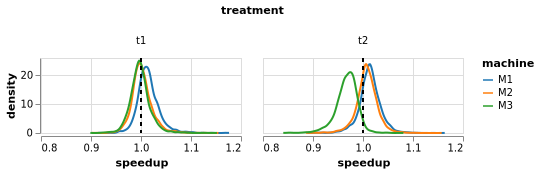

In [99]:
plot_effect_machine_treatment = effect_machines_h1 |>
    # df -> filter(r -> r[:treatment] == "t2", df) |>
    @vlplot(
        facet={column={field=:treatment}},
        spec={
            height=75,
            transform=[{density=:speedup, groupby=[:treatment, :machine]}],
            layer=[{x={field=:value, type=:quantitative, title="speedup"},
                    y={field=:density, type=:quantitative},
                    mark=:line, color={field=:machine, scale={scheme="category10"}}},
                   {mark={type=:rule, strokeDash=[4,4]}, x={datum=1.0, scale={zero=false}}}
                ]}
)

In [100]:
save("figures/plot_posterior_effect_machine_$benchmark.svg", plot_effect_machine_treatment)

We can see that the machine doesn't have strong interactions with treatments, but there is some effect to t2 on M3.

We'll plot the same data, but in the style of the other plots.

In [101]:
df_machines = chain_h1_to_df(treatments, "machine", machines, chain_h1)

6×8 DataFrame
 Row │ treatment  value    effect_type  effect_med  effect_50_min  effect_50_m ⋯
     │ String     String3  String       Float64     Float64        Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ t2         m1       interaction    1.01342        1.00202        1.0255 ⋯
   2 │ t2         m2       interaction    1.00748        0.996098       1.0195
   3 │ t2         m3       interaction    0.96947        0.955868       0.9812
   4 │ t1         m1       interaction    1.01227        1.00134        1.0250
   5 │ t1         m2       interaction    0.999975       0.989551       1.0121 ⋯
   6 │ t1         m3       interaction    0.997234       0.986221       1.0082
                                                               3 columns omitted

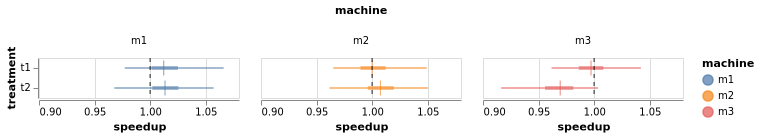

In [102]:
p2 = df_machines |> 
    @vlplot(
    # title="Effect of changes relative to baseline ($benchmark)",
    facet={column={field=:value, title="machine"}},
    spec={
        width=200,
        encoding={y={field=:treatment}, color={field=:value, title="machine"}},
        layer=[
            {:tick,
             x={field=:effect_med, title="speedup", scale={zero=false}}},
            {mark={type=:rule},
             x=:effect_95_min,
             x2=:effect_95_max},
            {mark={type=:rule, strokeWidth=4, opacity=0.5},
             color=:value,
             x=:effect_50_min,
             x2=:effect_50_max},
            {mark={type=:rule, opacity=0.5, strokeDash=[4,4]}, x={datum=1.0},
                y={value=0.0}, y2={value="height"}, color={value="black"}},
            ]
    },
)

In [103]:
save("figures/plot_effect_machine_$benchmark.svg", p2)

# Model 2.3 Correlated Noise

We'll re-use Model 2.2, except we also have one noise term per treatment.

In [104]:
@model function treatment_model_correlated_noise(
        nmachines, ntreatments,
        machine_idxs, warmup_idxs, treatment_idxs,
        running_time_obs_std, ::Type{T}=Float64) where T

    # We assume the mean running time is zero
    # (I think I have enough data-points to assume
    # there's little uncertainty about that, and centering is enough)

    # Effect of the machine
    sigma_machines ~ Exponential(0.5)
    # sigma_machines ~ LogNormal(-0.95, 0.44)
    effect_machine ~ MvNormal(Fill(0.0, nmachines), sigma_machines)

    # Effect of the warmup
    sigma_warmup ~ Exponential(0.5)
    # sigma_warmup ~ LogNormal(-1, 0.5)
    effect_warmup ~ MvNormal(Fill(0.0, 2), sigma_warmup)
    
    # Interaction warmup + machine
    # sigma_interactions_machine_warmup ~ Exponential(0.4)
    # effect_machine_warmup ~ filldist(Normal(0.0, sigma_interactions_machine_warmup),
    #                                  2, nmachines)

    # Effect of machine + Treatment
    # We saww that one was useless earlier.
    sigma_interactions_machine ~ Exponential(0.1)
    # Posterior for h0
    # sigma_interactions_machine ~ LogNormal(-2.89, 0.22)
    
    effect_interaction_machine ~ filldist(Normal(0.0, sigma_interactions_machine), nmachines, ntreatments)

    # Effect of warmup + treatment
    sigma_interactions_warmup ~ Exponential(0.05)
    # posterior for H0
    # sigma_interactions_warmup ~ LogNormal(-2.89, 0.22)
    effect_interaction_warmup ~ filldist(Normal(0.0, sigma_interactions_warmup),
                                         2, ntreatments)

    # One noise term per machine and warmup!
    sigma_noise ~ filldist(Exponential(0.1), ntreatments)

    N = length(running_time_obs_std)
    running_time = Vector{T}(undef, N)
    residuals = Vector{T}(undef, N)
    
    for i in 1:N
        machine_i = machine_idxs[i]
        warmup_i = warmup_idxs[i]
        treatment_i = treatment_idxs[i]

        effect_jvm = effect_machine[machine_i] + effect_warmup[warmup_i]
        
        effects_treatment_total = effect_interaction_warmup[warmup_i, treatment_i] + effect_interaction_machine[machine_i, treatment_i]

        # 0.0 is the average time
        running_time[i] = effect_jvm + effects_treatment_total

        running_time_obs_std[i] ~ Normal(running_time[i], sigma_noise[treatment_i])
        
        residuals[i] = running_time_obs_std[i] - running_time[i]
    end
    
    # Useful for the Bayesian R2
    line_variance = var(running_time)
    residuals_variance = var(residuals)
    R2 = line_variance / (line_variance + residuals_variance)
    
    return (#effect_machine_1=mean(effect_machine_warmup[:, 1]),
            #effect_machine_2=mean(effect_machine_warmup[:, 2]),
            #effect_machine_3=mean(effect_machine_warmup[:, 3]),
            #effect_startup=mean(effect_machine_warmup[1,:]),
            #effect_steady=mean(effect_machine_warmup[2,:]),
            r2=R2,
            finite_sd_noises=std(sigma_noise),
            finite_sd_machine=std(effect_machine),
            finite_sd_warmup=std(effect_warmup),
            finite_sd_treatment_machine=std(effect_interaction_machine),
            finite_sd_treatment_warmup=std(effect_interaction_warmup),
            finite_sd_residuals=std(running_time .- running_time_obs_std))
end

treatment_model_correlated_noise (generic function with 3 methods)

In [105]:
model_h2 = treatment_model_correlated_noise(length(machines),
                                        length(treatments),
                                        training[!, :machine_ids],
                                        training[!, :warmup_ids],
                                        training[!, :treatment_ids],
                                        training[!, :centered_log_running_time]);

In [106]:
chain_h2 = sample_model(model_h2);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/vetii/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/vetii/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/vetii/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/vetii/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true,

In [107]:
ess_rhat(chain_h2)

ESS
                       parameters         ess      rhat   ess_per_sec 
                           Symbol     Float64   Float64       Float64 

                   sigma_machines   2123.9912    1.0011        5.4842
                effect_machine[1]   1151.6404    1.0002        2.9736
                effect_machine[2]   1151.8930    1.0002        2.9742
                effect_machine[3]   1160.8700    1.0002        2.9974
                     sigma_warmup   2856.4357    1.0018        7.3754
                 effect_warmup[1]   1139.8924    1.0005        2.9432
                 effect_warmup[2]   1178.9457    1.0006        3.0441
       sigma_interactions_machine    385.8330    1.0047        0.9962
  effect_interaction_machine[1,1]   2442.7295    0.9993        6.3072
  effect_interaction_machine[2,1]   3182.8810    1.0012        8.2183
  effect_interaction_machine[3,1]   2925.0795    1.0010        7.5527
  effect_interaction_machine[1,2]   2024.6419    1.0005        5.2277
  effect_inte

In [108]:
indexin(["original"], treatments)

1-element Vector{Union{Nothing, Int64}}:
 1

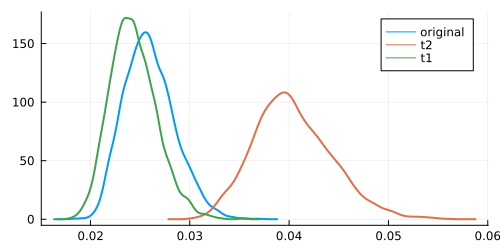

In [109]:
p = plot()
for t in 1:length(treatments)
    tmt = treatments[t]
    density!(chain_h2["sigma_noise[$t]"] |> vec, label=tmt, w=2, size=size_presentation)
end
p

We can see that for one t2, the variance is higher that for the other two. 

## Goodness of fit

In [110]:
model_h2_pred = treatment_model_correlated_noise(length(machines),
                                        length(treatments),
                                        test[!, :machine_ids],
                                        test[!, :warmup_ids],
                                        test[!, :treatment_ids],
                                        test[!, :centered_log_running_time]);

In [111]:
chain_h2_params = Turing.MCMCChains.get_sections(chain_h2, :parameters)
generated_h2 = generated_quantities(model_h2_pred, chain_h2_params);

In [112]:
r2_h2 = map(x -> x.r2, generated_h2) |> vec;

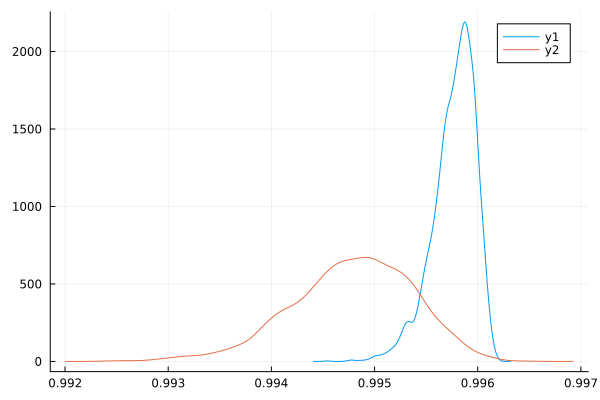

In [113]:
density(r2_h2)
density!(r2_h1)

There doesn't seem to be a major difference between model 2.2 and model 2.3.

In [114]:
function noise_chain_to_df(chain, treatments)
    baseline = indexin(["original"], treatments)[1]
    
    baseline_samples = chain["sigma_noise[$baseline]"] |> vec
    
    records = []
    
    for t_i in eachindex(treatments)
        t = treatments[t_i]
        
        if t == "original"
            continue
        end
        
        tmt_samples = chain["sigma_noise[$t_i]"] |> vec
        diff = tmt_samples .- baseline_samples
        for d in diff
            append!(records, [(treatment=t, difference=d)])
        end

    end
    
    return DataFrame(records)
end


noise_chain_to_df (generic function with 1 method)

In [115]:
noise_df = noise_chain_to_df(chain_h2, treatments);

In [116]:
combine(noise_df, :difference => mean)

1×1 DataFrame
 Row │ difference_mean 
     │ Float64         
─────┼─────────────────
   1 │      0.00641316

In [117]:
function interval_50_min(x)
    return quantile(x, 0.25)
end
function interval_50_max(x)
    return quantile(x, 0.75)
end
function interval_95_min(x)
    return quantile(x, 0.025)
end
function interval_95_max(x)
    return quantile(x, 0.975)
end

interval_95_max (generic function with 1 method)

In [118]:
noise_df = groupby(noise_df, :treatment) |> 
    df -> combine(df, 
        :difference .=> [median,
                     interval_95_min,
                     interval_95_max])

2×4 DataFrame
 Row │ treatment  difference_median  difference_interval_95_min  difference_in ⋯
     │ String     Float64            Float64                     Float64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ t2                0.0142128                   0.00568007                ⋯
   2 │ t1               -0.00158277                 -0.0082786
                                                                1 column omitted

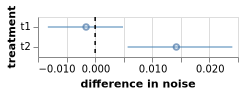

In [119]:
plot_difference_sigmas = noise_df |> 
    @vlplot(x={field=:difference_median, title="difference in noise"},
            y={field=:treatment},
            layer=[
                {mark={type=:rule, color="steelblue"},
                 x=:difference_interval_95_min,
                 x2=:difference_interval_95_max},
                {mark=:point, x={field=:difference_median}},
                {mark={type=:rule, strokeDash=[4,4]}, x={datum=0.0}, y={value=0.0}, y2={value="height"}}
        ])

In [120]:
save("figures/plot_difference_sigmas_$benchmark.svg", plot_difference_sigmas)

We can see that the fastest treatment makes the benchmark a little more unstable on average. It's small but it's also *definitely not zero*. 

A "difference of sigmas" is hard to interpret, though.

# Posteriors for the importance of features


Our model are using sigmas for regularization, but they also compute an ANOVA!

We'll look that the posteriors of the $\sigma$ terms in the model, to see the importance of each feature.

In [121]:
function plot_prior_posterior(title, prior, posterior)
    p = density(posterior, plot_title=title, linecolor="black", linewidth=3, label="Posterior")

    plot!(p, prior, linecolor="gray", label="Prior")

    return p
end

plot_prior_posterior (generic function with 1 method)

In [122]:
rename_dict = Dict("sigma_machines" => "σ machine",
                   "sigma_treatments" => "σ treatment",
                   "sigma_warmup" => "σ warmup",
                   "sigma" => "σ residuals")

Dict{String, String} with 4 entries:
  "sigma"            => "σ residuals"
  "sigma_machines"   => "σ machine"
  "sigma_warmup"     => "σ warmup"
  "sigma_treatments" => "σ treatment"

In [123]:
df_sigmas_h0 = DataFrame(chain_h0) |> 
    df -> rename(df, rename_dict) |>
    DataFrames.stack |>
    df -> filter(r -> occursin("σ", r[:variable]), df) |>
    df -> groupby(df, :variable) |>
    df -> combine(df, :value .=> [median, interval_50_min, interval_50_max, interval_95_min, interval_95_max])

4×6 DataFrame
 Row │ variable     value_median  value_interval_50_min  value_interval_50_max ⋯
     │ String       Float64       Float64                Float64               ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ σ machine       0.373241               0.282934                0.509795 ⋯
   2 │ σ warmup        0.377061               0.275953                0.52885
   3 │ σ treatment     0.0895048              0.0667738               0.125447
   4 │ σ residuals     0.05188                0.0500821               0.053796
                                                               2 columns omitted

In [124]:
df_sigmas_h1 = DataFrame(chain_h1) |> 
    df -> rename(df, :sigma_machines => "σ machine",
        :sigma_warmup => "σ warmup",
        :sigma_interactions_machine => "σ interactions machine",
        :sigma_interactions_warmup => "σ interactions warmup",
        :sigma => "σ residuals") |>
    DataFrames.stack |>
    df -> filter(r -> occursin("σ", r[:variable]), df) |>
    df -> groupby(df, :variable) |>
    df -> combine(df, :value .=> [median,interval_50_min,interval_50_max,interval_95_min,interval_95_max])

5×6 DataFrame
 Row │ variable                value_median  value_interval_50_min  value_inte ⋯
     │ String                  Float64       Float64                Float64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ σ machine                  0.377198               0.287953              ⋯
   2 │ σ warmup                   0.365325               0.285059
   3 │ σ interactions machine     0.0181921              0.0132196
   4 │ σ interactions warmup      0.0869953              0.0698531
   5 │ σ residuals                0.0305565              0.0294186             ⋯
                                                               3 columns omitted

In [125]:
function plot_sigmas(df_sigmas)
    return df_sigmas |> 
        @vlplot(layer=[
        {mark=:point, x={field=:value_median, title="variance"},
         y={:variable, sort=:value_median}},
        # {mark={type=:rule, strokeWidth=4, color="steelblue", opacity=0.5}, 
        #  x=:value_interval_50_min, x2=:value_interval_50_max,
        #  y={:variable, sort=:value_median}},
        {mark={type=:rule, color="steelblue"}, x=:value_interval_95_min, x2=:value_interval_95_max,
         y={:variable, sort=:value_median}},
        ])
end

plot_sigmas (generic function with 1 method)

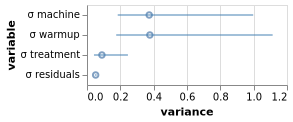

In [126]:
sigmas_h0_plot = plot_sigmas(df_sigmas_h0)

In [127]:
save("figures/plot-sigmas-no-interaction-$benchmark.svg", sigmas_h0_plot)
save("figures/plot-sigmas-no-interaction-$benchmark.pdf", sigmas_h0_plot)

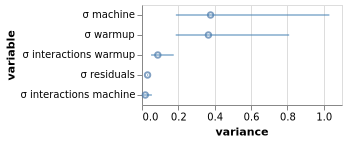

In [128]:
sigmas_h1_plot = plot_sigmas(sort(df_sigmas_h1, :value_median, rev=true))

In [129]:
save("figures/plot-sigmas-interactions-$benchmark.svg", sigmas_h1_plot)

## Finite variances

We can look at the posterior of the sigmas, but we can also compute it in the generated_quantities and use that instead. That typically gives values with much less uncertainty, Gelman says that which version to pick depends of the application.

In [130]:
chain_h0_parameters = Turing.MCMCChains.get_sections(chain_h0, :parameters)
gen_h0 = generated_quantities(model_h0, chain_h0_parameters);

In [131]:
# We make a dataframe...
df_gen_h0 = gen_h0 |> vec |> DataFrame;

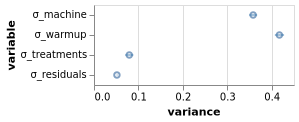

In [132]:
df_gen_h0 |>
    df -> df[!,Not(:r2)] |> 
    df -> rename(df, :finite_sd_machine => :σ_machine,
                 :finite_sd_warmup => :σ_warmup,
                 :finite_sd_treatments => :σ_treatments,
                 :finite_sd_residuals => :σ_residuals) |> DataFrames.stack |>
    df -> groupby(df, :variable) |>
    df -> combine(df, :value .=> [median, interval_50_min, interval_50_max, interval_95_min, interval_95_max]) |>
    plot_sigmas

As we can see, the error bars become very small.

In [133]:
df_gen_h1 = generated_quantities(model_h1, chain_h1_params) |> vec |> DataFrame;

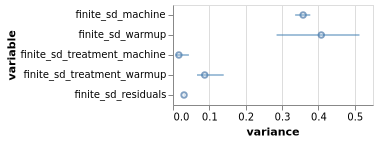

In [134]:
df_gen_h1 |> 
    df -> df[!,Not(:r2)] |>
    DataFrames.stack |>
    df -> groupby(df, :variable) |>
    df -> combine(df, :value .=> [median, 
        interval_50_min, interval_50_max, 
        interval_95_min, interval_95_max]) |>
    plot_sigmas

We can see that the interaction of treatment and machine is less important than the interaction between treatment and warmup. The interaction is even smaller than the sigma of the residuals.